In [1]:
cd ..

/home/martinsevilla/smoothness_langevin


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scipy
import langevin.langevin as lang
from langevin.utils import heat_diffusion_filter, compute_laplacian

np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

In [132]:
# Number of nodes
p = 5
# Number of measurements
n = 10
# Filter parameter
theta = 0.1
# Noise variance
sigma_e = 1

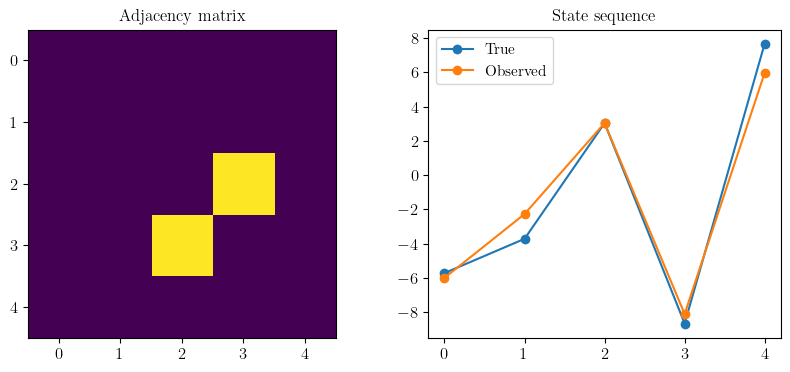

In [133]:
# Create adjacency matrix
A = torch.empty((p, p)).bernoulli_(0.25)
A = torch.triu(A) + torch.triu(A, 1).T
A.fill_diagonal_(0.0)
# Dynamics matrix
F = heat_diffusion_filter(A, theta)

e_dist = torch.distributions.Normal(0, sigma_e)

# Generate state and measurement sequence
X = torch.empty((p, n)).uniform_(-10, 10) # * torch.empty((p, n)).bernoulli_(0.8)
Y = F @ X + e_dist.sample((p, n))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A.cpu())
ax[0].set_title('Adjacency matrix')
ax[1].plot(X.T.cpu()[0], "-o", label="True")
ax[1].plot(Y.T.cpu()[0], "-o", label="Observed")
ax[1].set_title('State sequence')
ax[1].legend()
plt.show()

In [141]:
A_torch_original = A.clone().requires_grad_(True)
A_torch = torch.triu(A_torch_original) + torch.triu(A_torch_original, diagonal=1).T
F_torch = heat_diffusion_filter(A_torch, theta)

# Method 1
s = 0.0
for i in range(n):
    s = s +torch.linalg.norm(Y[:, i] - F_torch @ X[:, i]) ** 2
s = - 1 / (2 * sigma_e ** 2) * s
print("Torch gradient:", "\n", torch.autograd.grad(s, A_torch_original)[0])

# Method 2
A_torch = torch.triu(A_torch_original) + torch.triu(A_torch_original, diagonal=1).T
F_torch = heat_diffusion_filter(A_torch, theta)
s = - 1 / (2 * sigma_e ** 2) * (torch.linalg.norm(Y - F_torch @ X, dim=0) ** 2).sum() 
print("Torch gradient (more efficient):", "\n", torch.autograd.grad(s, A_torch_original)[0])

Torch gradient: 
 tensor([[ 0.0000,  0.8659, -1.1099, -0.8500,  1.6355],
        [ 0.0000,  0.0000,  1.2112, -0.0118,  3.3187],
        [ 0.0000,  0.0000,  0.0000, -1.3031, -1.1751],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.0396],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
Torch gradient (more efficient): 
 tensor([[ 0.0000,  0.8659, -1.1099, -0.8500,  1.6355],
        [ 0.0000,  0.0000,  1.2112, -0.0118,  3.3187],
        [ 0.0000,  0.0000,  0.0000, -1.3031, -1.1751],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.0396],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
